### Project Title: Titanic Survival Prediction
This project aims to predict Titanic passenger survival using machine learning models based on factors such as class, age, gender, and family size. The process involves data cleaning, feature engineering, and model evaluation to understand the key factors that impacted survival chances.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = sns.load_dataset("titanic")
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [3]:
df["survived"].unique()

array([0, 1], dtype=int64)

In [4]:
df["survived"].value_counts()

survived
0    549
1    342
Name: count, dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB


In [6]:
df.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

### Data Preprocessing 

In [7]:
# Handling Missing Values

df["age"].fillna(df["age"].median(), inplace=True)
df["embarked"].fillna(df["embarked"].mode()[0], inplace=True)
df["embark_town"].fillna(df["embark_town"].mode()[0], inplace=True)
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [8]:
# Dropping Deck column as it has too many null values

df.drop(columns="deck", inplace=True)

In [9]:
# Converting Categorical Columns into Numerical Columns

label_encoder = LabelEncoder()
df["sex"] = label_encoder.fit_transform(df["sex"])
df["embarked"] = label_encoder.fit_transform(df["embarked"])
df["embark_town"] = label_encoder.fit_transform(df["embark_town"])

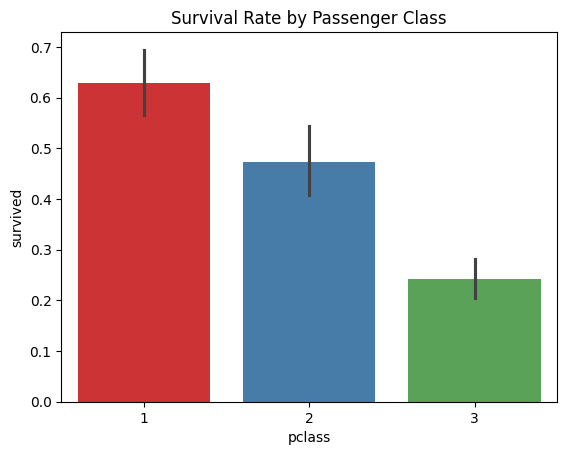

In [10]:
# Visualizing Survival rate by Class 

sns.barplot(x="pclass", y="survived", data=df, palette="Set1")
plt.title("Survival Rate by Passenger Class")
plt.show()

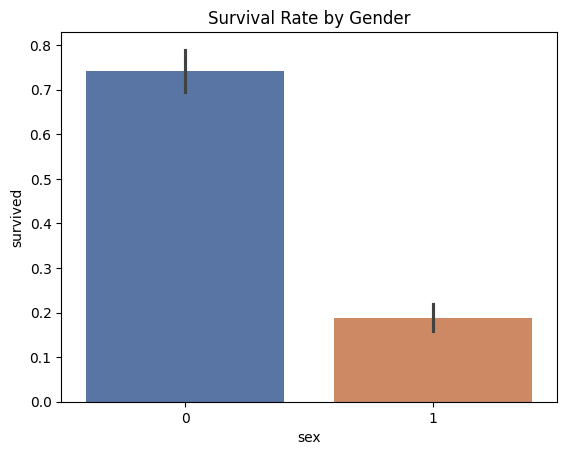

In [11]:
# Visualizing Survival rate by Sex 

sns.barplot(x="sex", y="survived", data=df, palette="deep")
plt.title("Survival Rate by Gender")
plt.show()

##### 0 = Female, 1 = Male



In [12]:
# Creating a new feature "family_size" by combining "sibsp"(siblings/spouse) & "parch"(parents/children)

df["family_size"] = df["sibsp"] + df["parch"] +1
df.drop(columns=["sibsp", "parch"], inplace=True)


In [13]:
# Dropping irrelevant columns

df.drop(columns=["class", "who", "adult_male", "alive",	"alone"], inplace=True) 

df.head()

,survived,pclass,sex,age,fare,embarked,embark_town,family_size
0,0,3,1,22.0,7.2500,2,2,2
1,1,1,0,38.0,71.2833,0,0,2
2,1,3,0,26.0,7.9250,2,2,1
3,1,1,0,35.0,53.1000,2,2,2
4,0,3,1,35.0,8.0500,2,2,1


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   survived     891 non-null    int64  
 1   pclass       891 non-null    int64  
 2   sex          891 non-null    int32  
 3   age          891 non-null    float64
 4   fare         891 non-null    float64
 5   embarked     891 non-null    int32  
 6   embark_town  891 non-null    int32  
 7   family_size  891 non-null    int64  
dtypes: float64(2), int32(3), int64(3)
memory usage: 45.4 KB


In [15]:
# Applying Standard Scaler

scaler = StandardScaler()

df[["age", "fare", "family_size"]] = scaler.fit_transform(df[["age", "fare", "family_size"]])

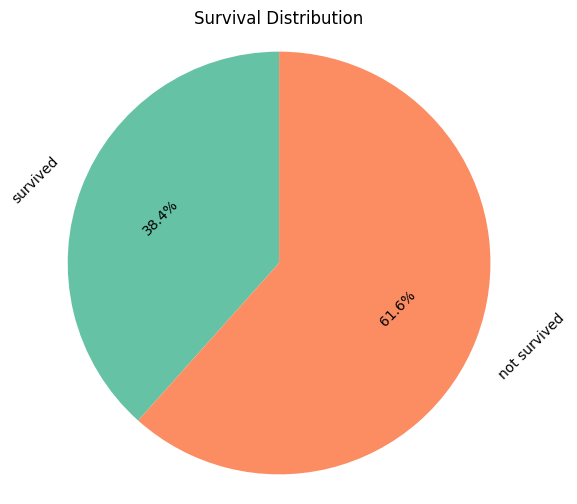

In [16]:
# Survived Distribution(Pie Chart)

plt.figure(figsize=(6, 6))
plt.pie([len(df[df["survived"] == 1]), len(df[df["survived"] == 0])], labels=["survived", "not survived"], autopct='%1.1f%%', startangle=90, textprops={'rotation':45}, colors=['#66c2a5','#fc8d62'])
plt.title("Survival Distribution")
plt.axis('equal')
plt.ylabel('')
plt.show()

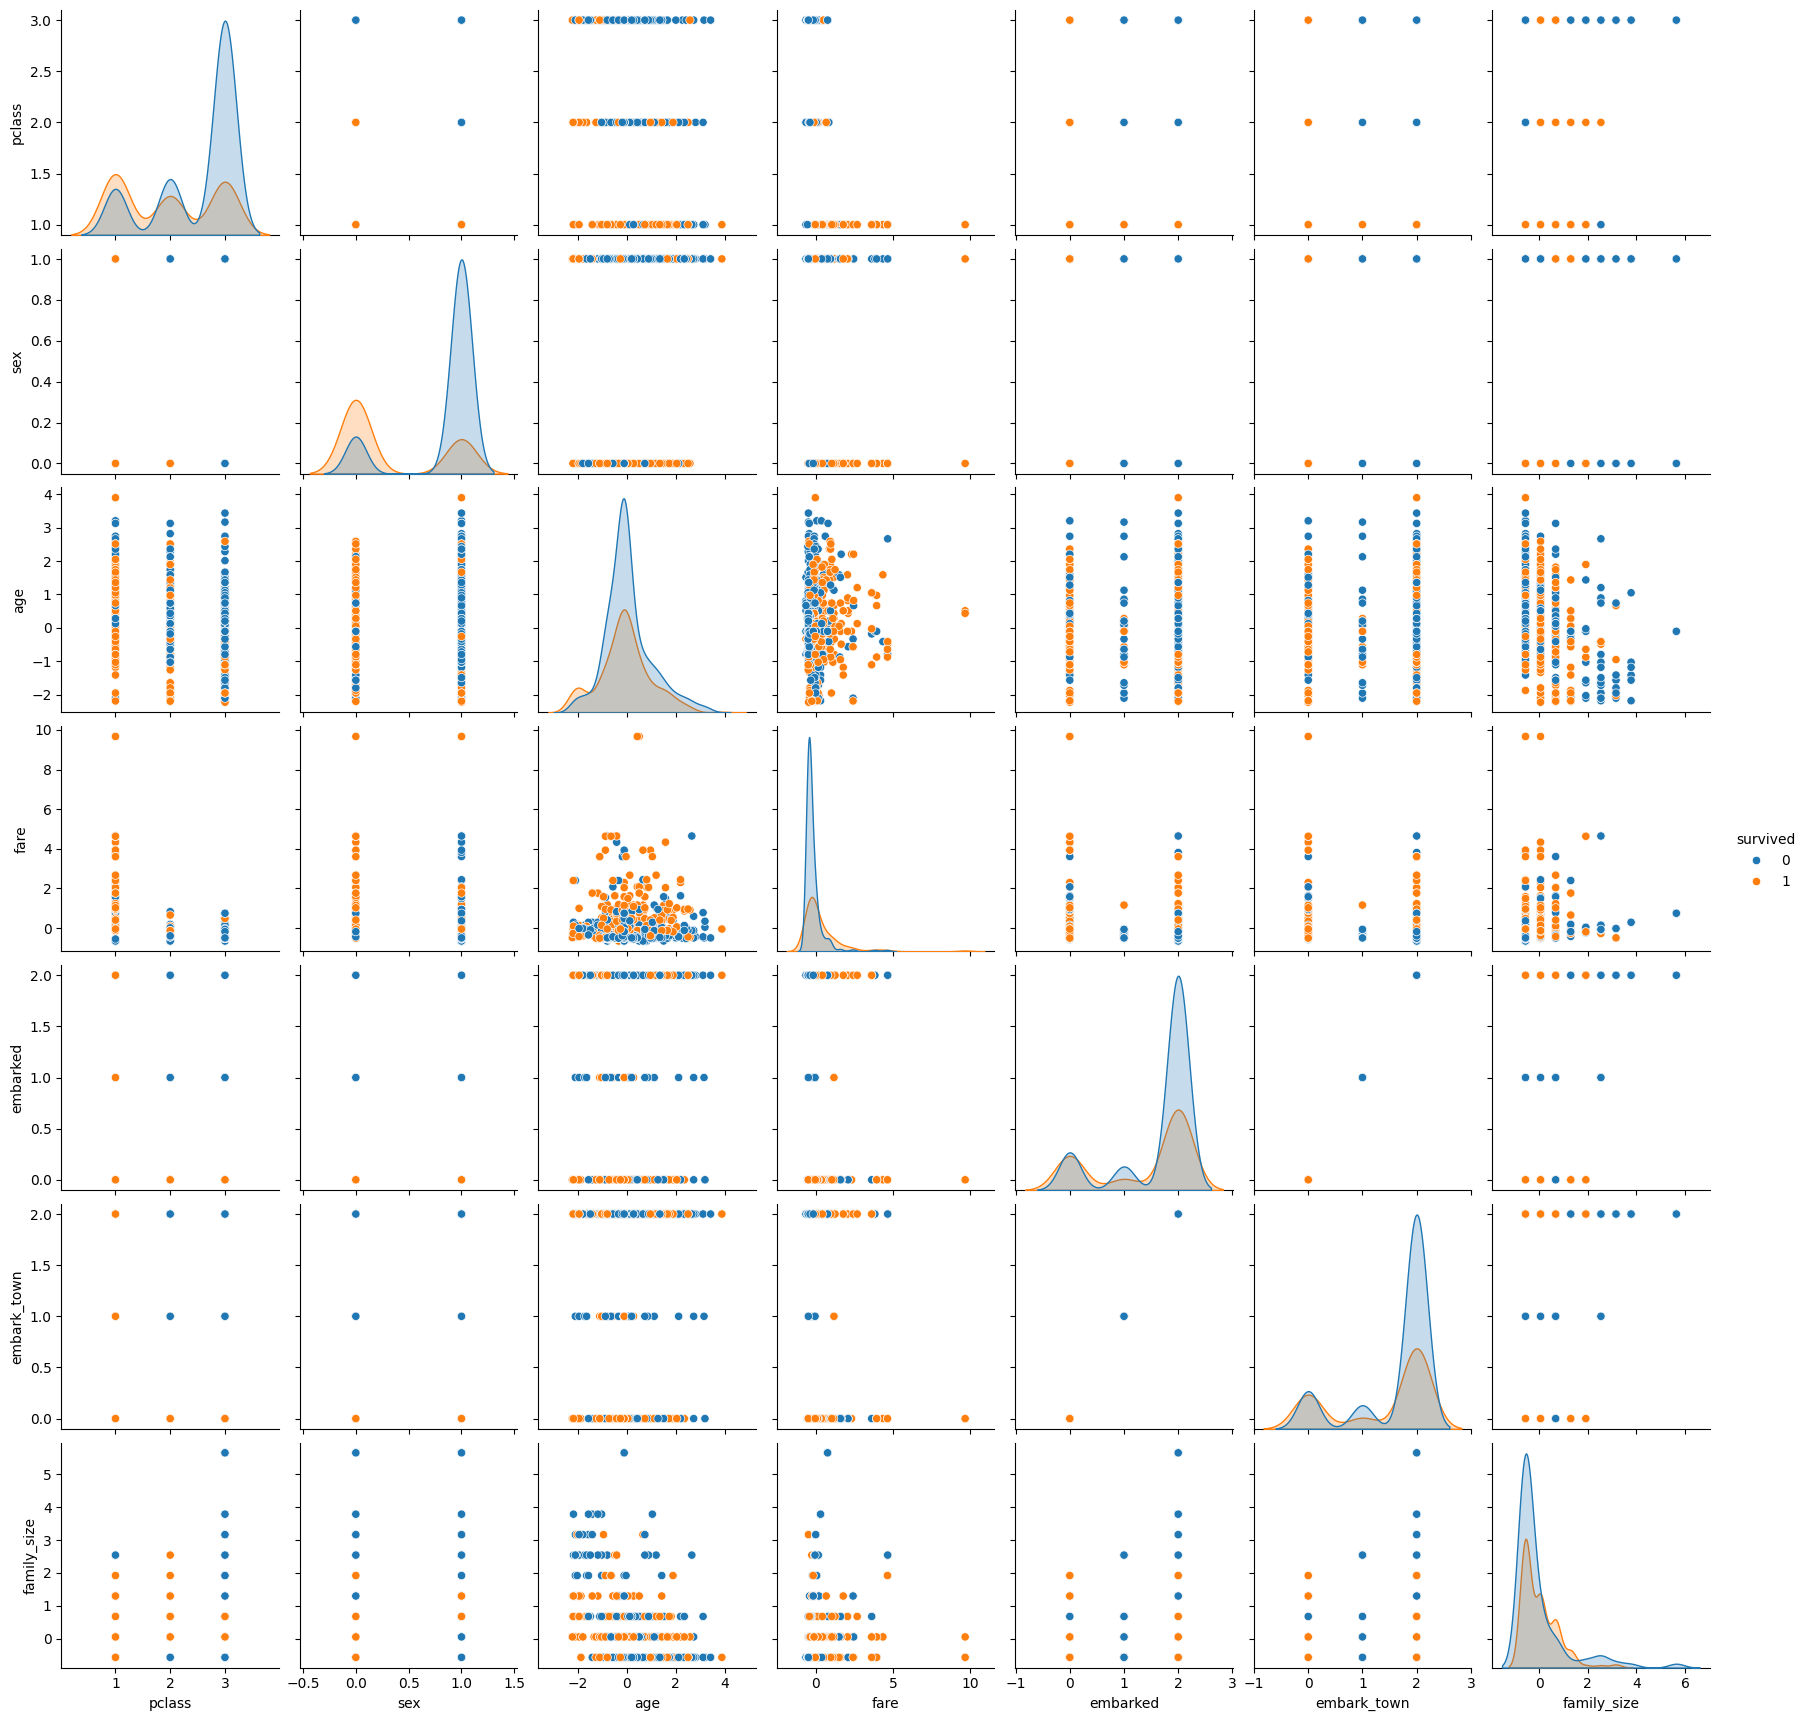

In [17]:
sns.pairplot(df, hue="survived")
plt.show()

### Splitting the data into Training & Testing sets

In [18]:
# Splitting the data into Training & Testing sets

x = df.drop(columns="survived") # Features(Independent Variables)
y= df["survived"] # Target(Dependent Variable)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

### Applying SMOTE to handle imbalance in the data

In [19]:
# Applying SMOTE

sm = SMOTE(random_state=42)
x_train_sm, y_train_sm = sm.fit_resample(x_train, y_train)

### Parameter Grid for Random Forest Classifier

In [20]:
# Defining Paramater Grid for Random Forest Classifier

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [21]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

In [22]:
# GridSearchCV

grid_search_rf = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1)
grid_search_rf.fit(x_train_sm, y_train_sm)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [4, 6, 8, 10],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]})

In [23]:
# Getting Best Parameters

print("Best Parameters:", grid_search_rf.best_params_)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 50}


In [24]:
# Using the best Estimators to Make Predictions

best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(x_test)

In [25]:
# Evaluating

accuracy_rf = best_rf.score(x_test, y_test)

# Print accuracy as a percentage
print("Random Forest Accuracy: {:.2f}%".format(accuracy_rf * 100))

print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 84.36%
Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.87      0.87       105
           1       0.81      0.81      0.81        74

    accuracy                           0.84       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.84      0.84      0.84       179



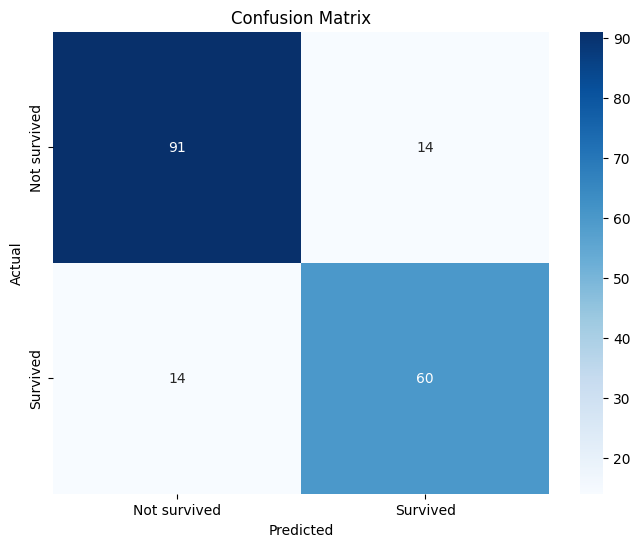

In [26]:
# Generating Confuusion Matrix

conf_matrix = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Not survived", "Survived"],
            yticklabels=["Not survived", "Survived"])
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.title("Confusion Matrix")
plt.show()

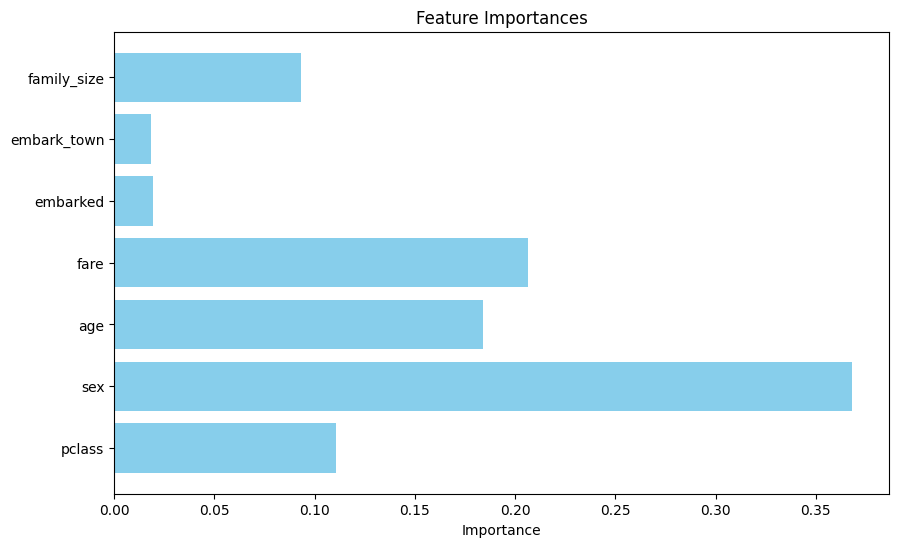

In [27]:
# Getting Feature Importance from the best Model

importance = grid_search_rf.best_estimator_.feature_importances_
features = x_train_sm.columns

plt.figure(figsize=(10, 6))
plt.barh(features, importance, color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances")
plt.show()

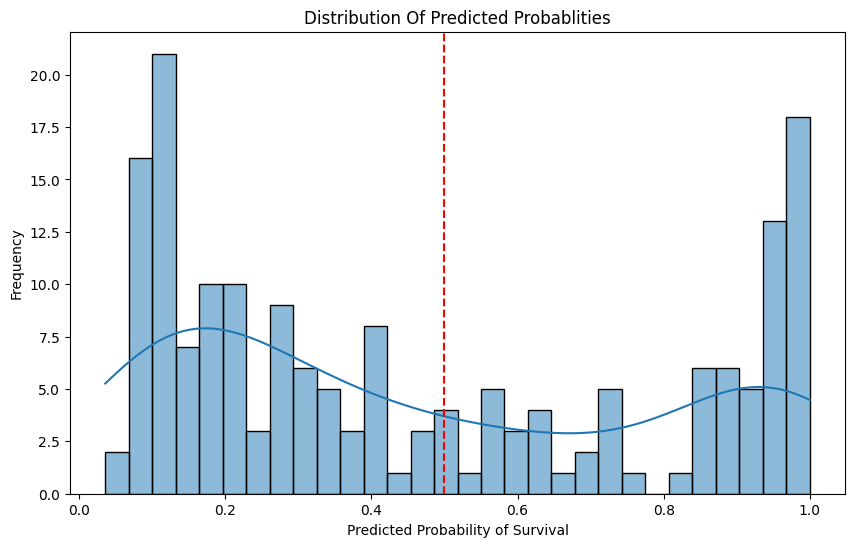

In [28]:
# Getting Predicted Probabilities for the test set

y_pred_proba = best_rf.predict_proba(x_test)[:, 1] # Probabilities for Class 1(Survived)

plt.figure(figsize=(10, 6))
sns.histplot(y_pred_proba, kde=True, bins=30)
plt.xlabel("Predicted Probability of Survival")
plt.ylabel("Frequency")
plt.axvline(x=0.5, color="red", linestyle= "--")  # Threshold Line
plt.title("Distribution Of Predicted Probablities")
plt.show()


### Insights:
#### Gender:
Female passengers had a significantly higher survival rate compared to males.
#### Class:
Passengers in higher classes (1st class) were more likely to survive.
#### Family Size: 
Moderate family sizes increased the chances of survival, while those traveling alone or in large families had lower survival rates.